<a href="https://colab.research.google.com/github/ambideXtrous9/GAN/blob/main/GAN_on_MS_COCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 46.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import json
import os
import cv2
from torch.nn import functional as F
from pathlib import Path
import torchvision
from google.colab.patches import cv2_imshow
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch import nn
import PIL
import torchvision.models as models

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [3]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [4]:
_URL = 'http://images.cocodataset.org/zips/val2014.zip'
zip_dir = tf.keras.utils.get_file('/content/MSCOCOVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/MSCOCOVAL2014.zip'
!unzip -q $fname -d /content/

6645013297/6645013297 [==============================] - 635s 0us/step


In [5]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/content/QUESVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/QUESVAL2014.zip'
!unzip -q $fname -d /content/

3494929/3494929 [==============================] - 2s 1us/step


In [6]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/content/ANNOTVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/ANNOTVAL2014.zip'
!unzip -q $fname -d /content/

10518930/10518930 [==============================] - 2s 0us/step


In [7]:
with open(os.path.join('/content/', 'v2_OpenEnded_mscoco_val2014_questions.json'), 'r') as f:
    val_questions = json.load(f)['questions']
with open(os.path.join('/content/', 'v2_mscoco_val2014_annotations.json'), 'r') as f:
    val_answers = json.load(f)['annotations']

In [8]:
val_data = []
for question, annotation in zip(val_questions, val_answers):
    question_text = question['question']
    image_id = annotation['image_id']
    answer = annotation['answers'][0]['answer']
    image_filename = 'COCO_val2014_{:012d}.jpg'.format(image_id)
    image_path = os.path.join('/content/', 'val2014', image_filename)
    val_data.append({'question': question_text, 'image_path': image_path, 'answer': answer})

In [9]:
# Convert the array of dictionaries to a DataFrame
df = pd.DataFrame(val_data)

In [10]:
def has_three_channels(image_path):
    with PIL.Image.open(image_path) as img:
        return img.mode == 'RGB'

# Filter the DataFrame to keep only the images with 3 channels
df = df[df['image_path'].apply(has_three_channels)]

In [11]:
def show_sample(idx=0):
  print("Q : ",df.iloc[idx]['question'])
  image = cv2.imread(df.iloc[idx]['image_path'])
  image = cv2.resize(image, (224, 224))  
  cv2_imshow(image)
  print("A : ",df.iloc[idx]['answer'])

Q :  What is the background metal structure?


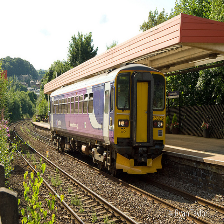

In [12]:
show_sample(100)

# **Model**

In [13]:
df = df[:10000]

In [14]:
train_df, val_df = train_test_split(df,test_size=0.1)

A :  trees


In [15]:
transform = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

In [16]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        
        return dict(img = image)

class ImageDataModule(pl.LightningDataModule):
    def __init__(self, train_df, batch_size=8, num_workers=4, transform=None):
        super().__init__()
        self.train_df = train_df
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def setup(self, stage=None):
        self.train_dataset = ImageDataset(self.train_df, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True, pin_memory=True)


In [17]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, 1024 * 4 * 4)
        self.conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 1024, 4, 4)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.tanh(self.conv4(x))
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(512 * 4 * 4, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = x.view(-1, 512 * 4 * 4)
        x = torch.sigmoid(self.fc(x))
        return x

In [18]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim: int = 64, lr: float = 0.0002, b1: float = 0.5, b2: float = 0.999):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim)
        self.discriminator = Discriminator()

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx, optimizer_idx):
        real_images = batch['img']
        batch_size = real_images.size(0)
        device = real_images.device
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        if optimizer_idx == 0: # Train generator
            z = torch.randn(batch_size, self.hparams.latent_dim, device=device)
            gen_images = self.generator(z)
            g_loss = F.binary_cross_entropy(self.discriminator(gen_images), valid)
            self.log('g_loss', g_loss)
            return g_loss
        else: # Train discriminator
            z = torch.randn(batch_size, self.hparams.latent_dim, device=device)
            gen_images = self.generator(z).detach()

            real_loss = F.binary_cross_entropy(self.discriminator(real_images), valid)
            fake_loss = F.binary_cross_entropy(self.discriminator(gen_images), fake)
            d_loss = (real_loss + fake_loss) / 2
            self.log('d_loss', d_loss)
            return d_loss

    def configure_optimizers(self):
        lr = self.hparams.lr
        betas = (self.hparams.b1, self.hparams.b2)
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=betas)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=betas)
        return [opt_g, opt_d], []

    def train_epoch_end(self):
        z = torch.randn(8, self.hparams.latent_dim, device=self.device)
        sample_imgs = self.generator(z)
        grid = torchvision.utils.make_grid(sample_imgs, nrow=4, normalize=True)
        self.logger.experiment.add_image('generated_images', grid, global_step=self.current_epoch)


In [19]:
BATCH_SIZE = 8
N_EPOCHS = 10

In [20]:
data_module = ImageDataModule(df, batch_size=BATCH_SIZE, 
                              num_workers=4, transform=transform)
data_module.setup()

In [21]:
model = GAN()

In [22]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'best_cp',
    save_top_k = 1,
    verbose = True,
    monitor = 'd_loss',
    mode = 'min')

In [23]:
trainer = pl.Trainer(gpus=1,
    callbacks=[checkpoint_callback],
    max_epochs = N_EPOCHS)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 12.1 M
1 | discriminator | Discriminator | 2.8 M 
------------------------------------------------
14.8 M    Trainable params
0         Non-trainable params
14.8 M    Total params
59.387    Total estimated model params size (MB)
/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 2500: 'd_loss' reached 0.55019 (best 0.55019), saving model to '/content/checkpoints/best_cp.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 5000: 'd_loss' reached 0.50111 (best 0.50111), saving model to '/content/checkpoints/best_cp.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 7500: 'd_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 10000: 'd_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 12500: 'd_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 15000: 'd_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 17500: 'd_loss' reached 0.41142 (best 0.41142), saving model to '/content/checkpoints/best_cp.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 20000: 'd_loss' reached 0.21103 

In [25]:
import matplotlib.pyplot as plt

In [26]:
def generate_image(num_images : int):
    checkpoint_path = "/content/checkpoints/best_cp.ckpt"
    model = GAN.load_from_checkpoint(checkpoint_path)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        # Generate the output image
        z = torch.randn(num_images, model.hparams.latent_dim, device=device)
        output_image = model.generator(z)
        output_image = output_image.detach().cpu().numpy()

    output_image = ((output_image + 1) / 2 * 255).astype(np.uint8)

    imgs = []
    for i in range(num_images):
        img = output_image[i].transpose((1, 2, 0))
        img = cv2.resize(img, (200, 200))
        imgs.append(img)
    result = cv2.hconcat(imgs)
    cv2_imshow(result)


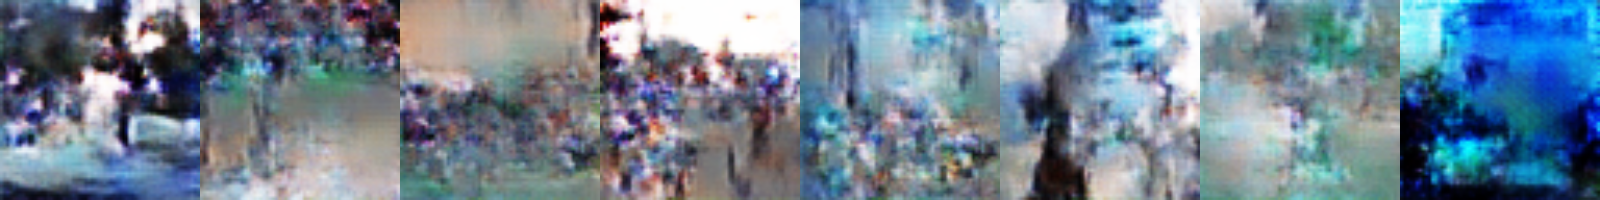

In [27]:
generate_image(8)